In [239]:
%load_ext google.cloud.bigquery
%load_ext autoreload
%autoreload 2

from dotenv import find_dotenv, load_dotenv
import matplotlib.pyplot as plt
from src.visualization import visualize
import pandas as pd
import numpy as np
from google.cloud import bigquery
from src.data.scraped_tokopedia import ScrappedTokopedia
from src.data.get_dataset import Dataset
import seaborn as sns

# find .env automagically
load_dotenv(find_dotenv())

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [183]:
dataset = Dataset()

In [187]:
clean_data = dataset.get_clean_dataset()
scraped_tokped = ScrappedTokopedia()
crawled_data = scraped_tokped.get_full_data()

In [190]:
full_data = pd.merge(clean_data, crawled_data, left_on="shop_domain", 
                     right_on="shop_domain", how="left")

# How many active products that most tokopedia applicants have ?
we limit the crawler to only scrape 500 product ranked by number of purchase for all the applicant. By having the products informatino, we can know the price range and the type of the products they sell, But are 500 products enough as a representation or too much ?

In [191]:
full_data['active_products'].describe()

count     2662.000000
mean       633.472953
std       2340.311791
min          0.000000
25%         48.000000
50%        145.000000
75%        450.000000
max      55509.000000
Name: active_products, dtype: float64

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


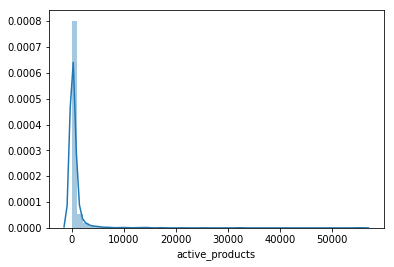

In [192]:
sns.distplot(full_data['active_products'].fillna(0))

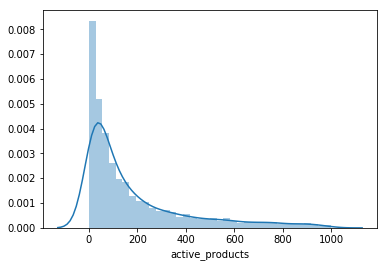

In [193]:
sns.distplot(crawled_data[crawled_data['active_products'] < 1000]['active_products'].fillna(0))

it seems like 75% of all the tokopedia applicant have less than 500 products. Tokopedia by default has limited the number of products that we can see in the website by 2500 products.

# What type of product did most of our applicants sell ?

In [282]:
top_category = full_data.groupby(['dominant_category_name']) \
    .size() \
    .reset_index() \
    .rename(columns={0:'num_applicants'}) \
    .sort_values('num_applicants', ascending=False)
top_category['num_applicants'] = top_category['num_applicants'] / top_category['num_applicants'].sum()

# visualize
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.set_color_codes("pastel")
sns.barplot(x="num_applicants", 
            y="dominant_category_name", 
            data=top_category,
            label="% of all applicants", color="b")

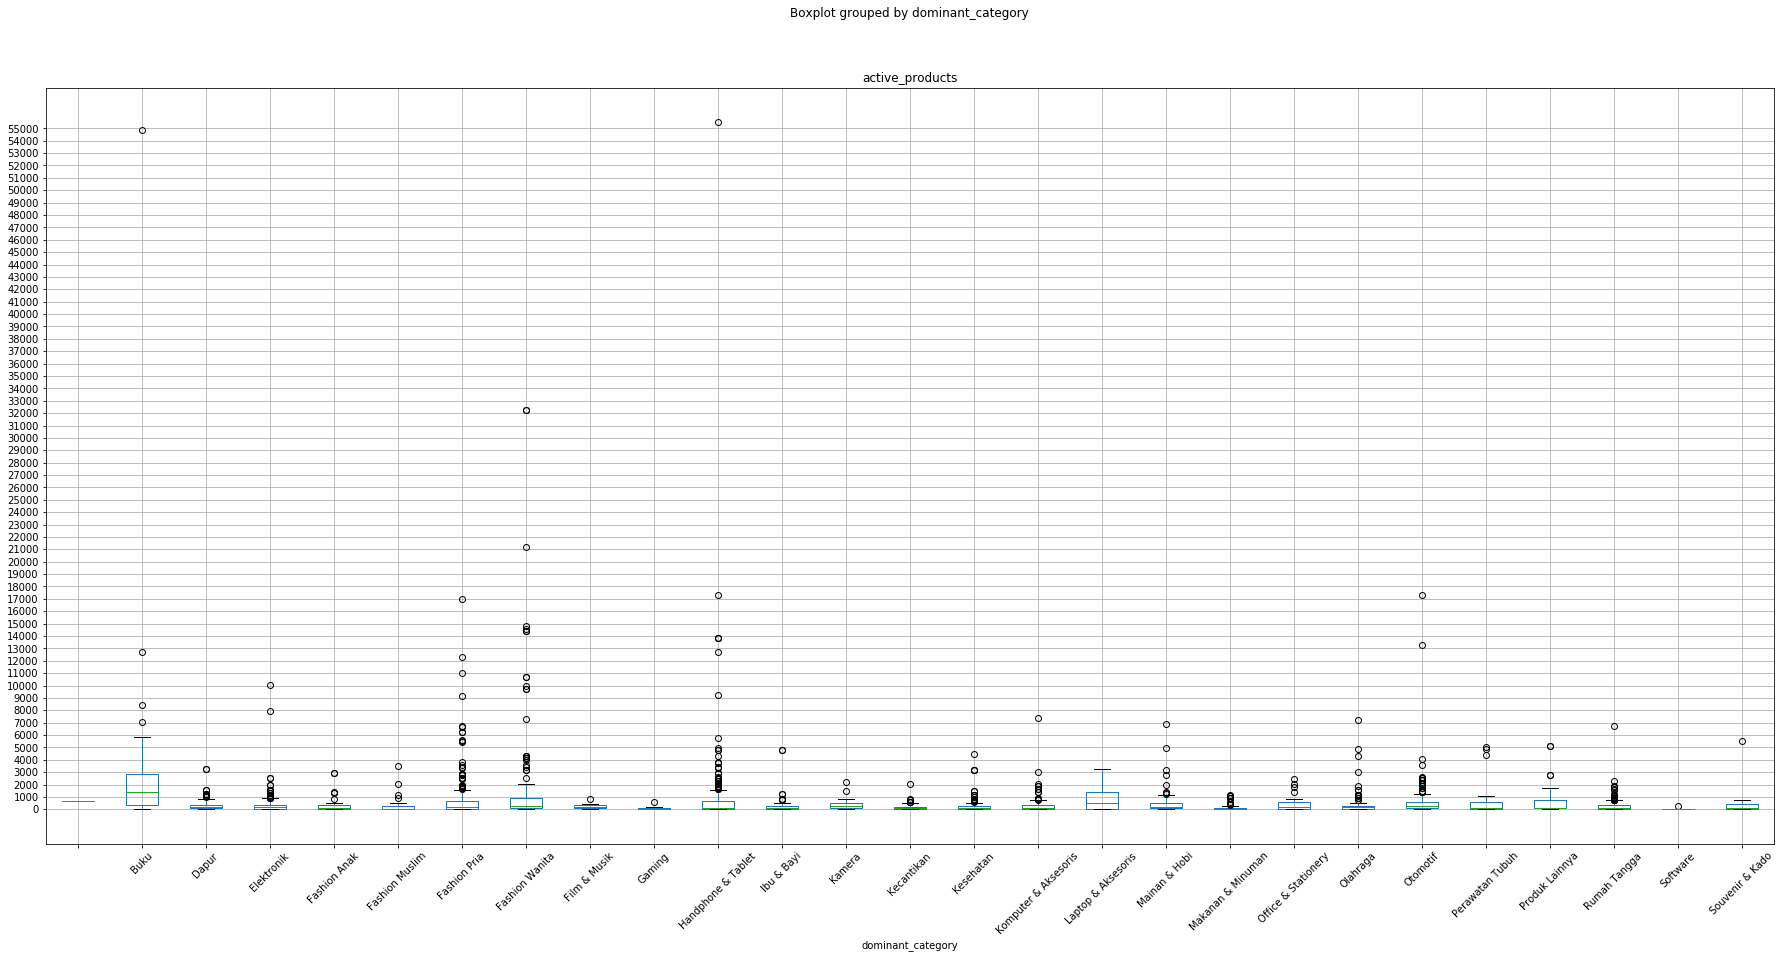

In [162]:
fig,ax = plt.subplots( figsize=(30,14))
full_data.boxplot(column=['active_products'],
                         rot=45, 
                         by='dominant_category',
                         ax=ax)
plt.yticks(np.arange(0, full_data['active_products'].max(), step=1000))
plt.show()

<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>

In [287]:
top_department = full_data.groupby(['dominant_department_name']) \
    .size() \
    .reset_index() \
    .rename(columns={0:'num_applicants'}) \
    .sort_values('num_applicants', ascending=False)
default = full_data.groupby(['dominant_department_name','default']).size().reset_index().rename(columns={0:'num_default'})
top_department = pd.merge(top_department,default,on='dominant_department_name')
top_department = top_department[top_department['default'] > 0]

# visualize
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 20))

sns.set_color_codes("pastel")
sns.barplot(x="num_applicants", 
            y="dominant_department_name", 
            data=top_department.head(50),
            label="% of all applicants", color="b")

sns.set_color_codes("muted")
sns.barplot(x="num_default", y="dominant_department_name", data=top_department.head(50),
            label="% of default", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)

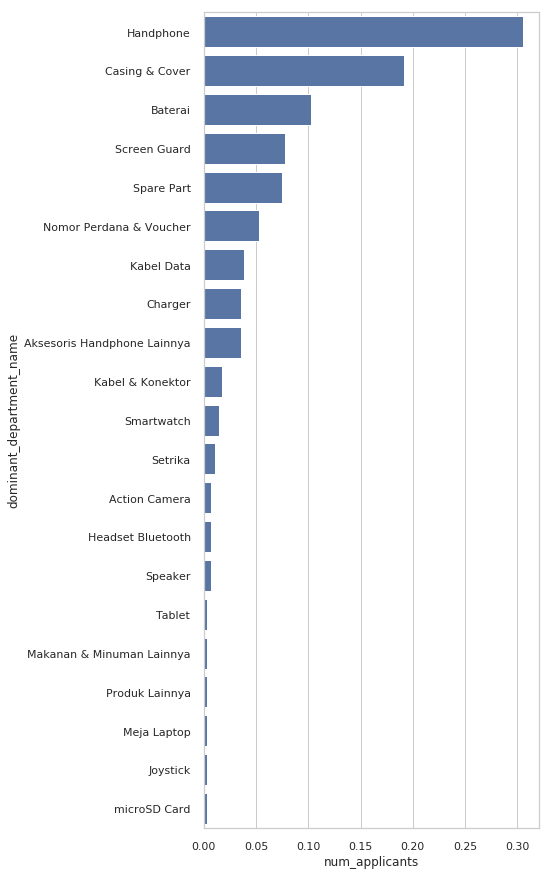

In [275]:
handphone = full_data[full_data['dominant_category_name'] == 'Handphone & Tablet'].groupby(['dominant_department_name']) \
    .size() \
    .reset_index() \
    .rename(columns={0:'num_applicants'}) \
    .sort_values('num_applicants', ascending=False)
handphone['num_applicants'] = handphone['num_applicants'] / handphone['num_applicants'].sum()
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x="num_applicants", 
            y="dominant_department_name", 
            data=handphone,
            label="% of all applicants", color="b")

In [228]:
full_data['dominant_percentage'] = full_data['num_dominant_category_name'] / full_data['active_products']

In [233]:
full_data.groupby(['dominant_category_name'])['dominant_percentage'].median().sort_values()

dominant_category_name
                        0.200573
Buku                    0.313569
Fashion Wanita          0.496377
Produk Lainnya          0.532349
Laptop & Aksesoris      0.576923
Dapur                   0.583333
Perawatan Tubuh         0.604478
Kesehatan               0.610783
Souvenir & Kado         0.614512
Ibu & Bayi              0.643137
Fashion Anak            0.644737
Olahraga                0.665333
Office & Stationery     0.667377
Komputer & Aksesoris    0.681435
Fashion Pria            0.681849
Rumah Tangga            0.720000
Handphone & Tablet      0.726036
Elektronik              0.737864
Gaming                  0.743508
Kecantikan              0.769231
Mainan & Hobi           0.822782
Fashion Muslim          0.840491
Film & Musik            0.858491
Kamera                  0.908530
Makanan & Minuman       0.925926
Otomotif                0.936027
Software                0.950000
Name: dominant_percentage, dtype: float64

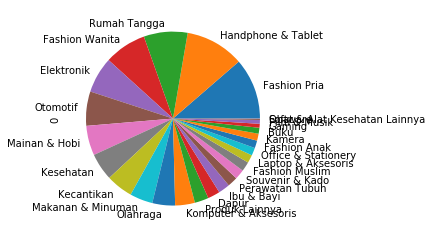

In [94]:
top_department.sort_values(0, ascending=False).set_index(['category_name'])[0].plot.pie()

In [40]:
crawled_data['row_number'] = crawled_data.index